<a href="https://colab.research.google.com/github/BoYeonJang/ICT-AI-education/blob/main/(8%EC%9B%94%204%EC%9D%BC)%20%EC%89%BD%EA%B2%8C%20%EC%84%A4%EB%AA%85%ED%95%98%EB%8A%94%20%EB%94%A5%EB%9F%AC%EB%8B%9D/cats_vs_dogs_transfer_%EA%B0%95%EC%9D%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN과 Transfer Learning으로 cats vs dogs 문제를 풀어봅시다

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

#from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 1. 데이터셋 준비
### train data 80% test data 20%
### `BATCH_SIZE`와 `EPOCHS`(시간상 5) 를 정의합니다. 나중에 따로 EPOCHS = 20으로 하고 돌려보시길 바랍니다.

In [2]:
BATCH_SIZE = 64
EPOCHS = 5
dataset_name = 'cats_vs_dogs'
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_dataset, validation_dataset), info = tfds.load(name=dataset_name, split=('train[:80%]', 'train[-20%:]'), with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteA8UG59/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


# 2. 데이터 프리프로세싱

### 이미지에 대한 Normalization 합니다.
### 이미지는 0 ~ 255 까지 integer. tf.cast는 float로 바꾸고 255로 나누면 0~1까지 소수로 변경됨.  
### 이미지는 모두 같은 size로 만들어야 tensorflow에 입력이 가능함

In [3]:
def normalize(images):
    # 0~1 사이의 값으로 Normalize 합니다.
    img, lbl = tf.cast(images['image'], tf.float32) / 255.0, images['label']
    # 300 X 300 사이즈로 resize 합니다.
    img = tf.image.resize(img, size=(300, 300))
    return img, lbl

`normalize`를 수행합니다.

`Training Set`와 `Validation Set`을 만들고 **BATCH_SIZE**에 따라 mini batch를 만듭니다.

In [4]:
train_data = train_dataset.map(normalize).batch(BATCH_SIZE).repeat().prefetch(1)
valid_data = validation_dataset.map(normalize).batch(BATCH_SIZE).repeat().prefetch(1)

`steps_per_epoch`과 `validation_steps`를 정의하여 train 합니다.

In [5]:
#steps_per_epoch= int(len(list(train_data)) * 0.8) // BATCH_SIZE + 1
#validation_steps= int(len(list(validation_data)) * 0.2) // BATCH_SIZE + 1
steps_per_epoch=582
validation_steps=146

# 4. 모델 설계하기(CNN) 

In [6]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Flatten(), 
    Dense(512, activation='relu'), 
    Dense(32, activation='relu'), 
    Dense(1, 'sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. 모델 모니터링하기

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss', 
        verbose=1)

# 5. 모델 학습하기

In [8]:
cnn_history = model_cnn.fit(train_data, 
                            validation_data=(valid_data),
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            epochs=EPOCHS, 
                            callbacks=[checkpoint, early_stopping])
model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("cats-dogs-cnn.h5")     

Epoch 1/5
582/582 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.6662
Epoch 1: val_loss improved from inf to 0.46616, saving model to checkpoint.ckpt
582/582 [==============================] - 122s 186ms/step - loss: 0.5869 - accuracy: 0.6662 - val_loss: 0.4662 - val_accuracy: 0.7842
Epoch 2/5
582/582 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 0.8289
Epoch 2: val_loss improved from 0.46616 to 0.33798, saving model to checkpoint.ckpt
582/582 [==============================] - 104s 178ms/step - loss: 0.3834 - accuracy: 0.8289 - val_loss: 0.3380 - val_accuracy: 0.8538
Epoch 3/5
582/582 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.8921
Epoch 3: val_loss did not improve from 0.33798
582/582 [==============================] - 103s 177ms/step - loss: 0.2580 - accuracy: 0.8921 - val_loss: 0.3511 - val_accuracy: 0.8586
Epoch 4/5
582/582 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9257
Epoc

In [9]:
model_cnn.load_weights(checkpoint_path)                      
model_cnn.save("cats-dogs-cnn.h5")     

## Transfer Learning (VGG 16)

**VGG-16**은 ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 컨벌루션 신경망입니다. 이 네트워크에는 16개의 계층이 있으며, 영상을 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 그 결과 이 네트워크는 다양한 영상을 대표하는 다양한 특징을 학습했습니다. 

**VGG-16모델**을 활용하여 Transfer Learning 을 진행합니다.

In [10]:
#Image('https://s3.ap-south-1.amazonaws.com/techleer/309.jpg')

### include_top 은 실제 vgg16의 마지막 부분인 분류기 (softmax를 포함한 1000개 category로 분류)를 포함하냐(True), 마느냐(False)를 선택합니다. 우리는 cat 이냐 dog 이냐를 분류하려고 하므로 False로 합니다.

In [11]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

58900480/58889256 [==============================] - 0s 0us/step


### 불러오는 vgg16은 새로 학습할 것이 아니므로 trainable = False로 합니다.

In [12]:
transfer_model.trainable=False

In [13]:
model_tr = Sequential([
    transfer_model, 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(1, 'sigmoid')
    ])

In [14]:
model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
transfer_history = model_tr.fit(train_data, 
                             validation_data=(valid_data),
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps,
                             epochs=EPOCHS, 
                             callbacks=[checkpoint, early_stopping])
model_tr.load_weights(checkpoint_path)                      
model_tr.save("cats-dogs-tr.h5")      

Epoch 1/5
582/582 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9240
Epoch 1: val_loss improved from 0.33798 to 0.16901, saving model to checkpoint.ckpt
582/582 [==============================] - 467s 786ms/step - loss: 0.2038 - accuracy: 0.9240 - val_loss: 0.1690 - val_accuracy: 0.9252
Epoch 2/5
582/582 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9659
Epoch 2: val_loss improved from 0.16901 to 0.13444, saving model to checkpoint.ckpt
582/582 [==============================] - 454s 781ms/step - loss: 0.0954 - accuracy: 0.9659 - val_loss: 0.1344 - val_accuracy: 0.9435
Epoch 3/5
582/582 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9703
Epoch 3: val_loss did not improve from 0.13444
582/582 [==============================] - 454s 781ms/step - loss: 0.0740 - accuracy: 0.9703 - val_loss: 0.1370 - val_accuracy: 0.9435
Epoch 4/5
582/582 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9762


## 성능 Visualization

**Losses** 와 **Accuracy**를 보면, Transfer Learning 모델이 훨씬 초기 수렴이 빠를 뿐더러, 최종 성능도 accuracy 기준 **약 10%** 가량 우수하다는 것을 확인할 수 있습니다.

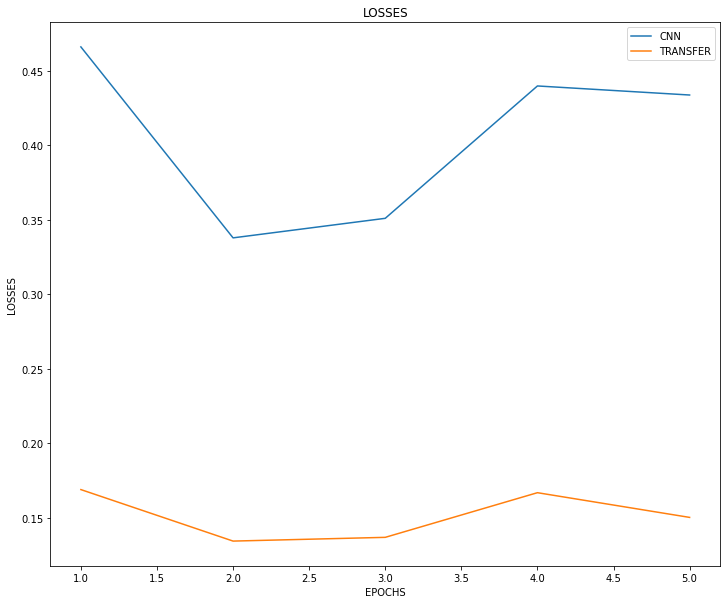

In [16]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(1, EPOCHS+1), cnn_history.history['val_loss'], label='CNN')
plt.plot(np.arange(1, EPOCHS+1), transfer_history.history['val_loss'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()

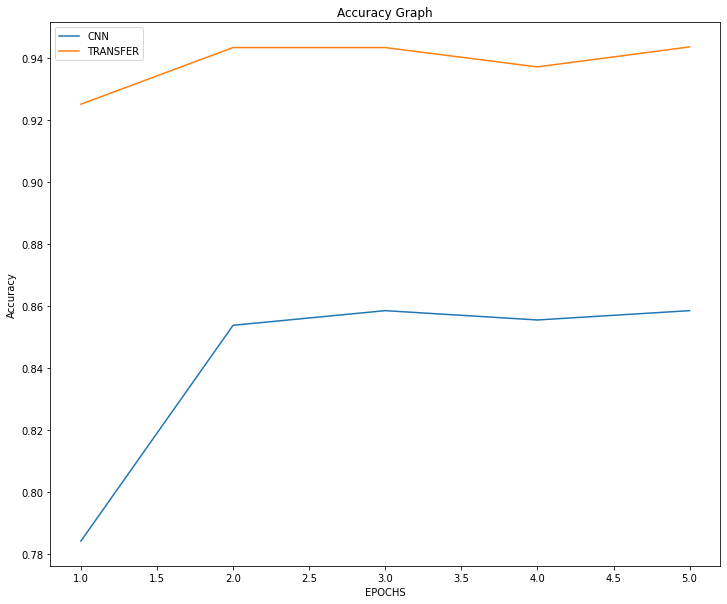

In [17]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(1, EPOCHS+1), cnn_history.history['val_accuracy'], label='CNN')
plt.plot(np.arange(1, EPOCHS+1), transfer_history.history['val_accuracy'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

In [ ]:
!pip install netron
# https://lutzroeder.github.io/netron/